 # Проект: Выявление профилей покупателей и анализ товарного ассортимента интернет-магазина


В нашем распоряжении данные о покупателях и их покупках интернет-магазина товаров для дома «Пока все ещё тут».


Задача проекта: выявление профилей покупателей, а также полноценный анализ товарного ассортимента с целью улучшение рекламной компании и увеличение прибыли соответсвенно. 

Датасет исходных данных состоит из следующих колонок: 

date — дата заказа;

customer_id — идентификатор покупателя;

order_id — идентификатор заказа;

product — наименование товара;

quantity — количество товара в заказе;

price — цена товара.

## Предобработка и предварительный анализ данных 

Импортируем нужные библиотеки для работы, прочитаем файл с датасетом, изучим основные характеристики данных

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from plotly import graph_objects as go

Откроем файл и посмотри первые строки датасета:

In [2]:
dataset = pd.read_csv('C:/Users/asus/Downloads/ecom_dataset_upd.csv', sep=',')
dataset.head(10)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


Посмотрим кратко информацию о данных, заодно информацию о пропусках:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


На старте у нас 7 474 строки с данными о покупках, пропусков по датасету нет; названия 6ти столбцов выглядят корректно, необходи изменить тип данных в колонках date (привести к формату даты) и добавим столбец с номером месяца и года покупки, наименования товаров в колонке product приведем к единому нижнему регистру, навсякий случай буквы ё заменим на е.

In [4]:
# приводим столбец с датой к соответствующему типу данных:
dataset['date'] = pd.to_datetime(dataset['date'], format = '%Y%m%d%H')

In [5]:
# добавляю столбец month  с номером месяца покупки и годом
dataset['year_month'] = dataset['date'].dt.strftime('%Y-%m')
dataset.head()

,date,customer_id,order_id,product,quantity,price,year_month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10


In [6]:
# приводим названия товаров к нижнему регистру без букв ё:
dataset['product'] = dataset['product'].str.lower().replace('ё', 'е', regex=False)
dataset

,date,customer_id,order_id,product,quantity,price,year_month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10
...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01


Далее проверим наличие дубликатов: дубликатами будем считать одновременное совпадение в customer_id — идентификатор покупателя, order_id — идентификатор заказа, product — наименование товара, quantity — количество товара в заказе.

In [7]:
# проверим наличие явных дубликатов по датасету:
dataset.duplicated().sum()

0

In [8]:
duplicates_by_columns = dataset[dataset.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity'])]
duplicates_by_columns

,date,customer_id,order_id,product,quantity,price,year_month
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,2018-10
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0,2018-10
...,...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,2019-10
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,мирт d-9 см h-15 см,1,134.0,2019-10
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,2019-10
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397.0,2019-10


Что ж, 1 866 дубликатов, почти четверть от всего датасета: если посмотреть на первые 4 дубликата, то можно предположить, что причина возникновения дубликатов - сбой в системе: она добавляет один и тот же заказ с разницей в пару часов (возможно, были проблемы с оплатой). 

Удаляю дубликаты, оставив последний встречающийся вариант - думаю, его можно считать самым корректным:

In [9]:
dataset.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity'], keep='last', inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset

,date,customer_id,order_id,product,quantity,price,year_month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10
...,...,...,...,...,...,...,...
5603,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01
5604,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01
5605,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01
5606,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01


Данный вид дубликатов удален, но также может встретиться ситуация, что одному номеру заказа соответствует несколько пользователей, выясним этот момент:

In [10]:
customers_m = dataset.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')
print(f"Количество дубликатов: {len(customers_m)}")
# считаем длину полученной таблицы
double = len(customers_m)/len(dataset)*100
print(f"доля дубликатов от общего очищенного датасате: {double:.2f}%")

Количество дубликатов: 29
доля дубликатов от общего очищенного датасате: 0.52%


Доля таких дубликатов не велика, так что думаю, их можно удалить полностью, без замен и т.п.

In [11]:
order_id_list = list(customers_m.index)

In [12]:
# исключаем из датасета тех, кто повторялись
data_set=dataset[~dataset['order_id'].isin(order_id_list)]
# сброс индекса
data_set.reset_index(drop=True, inplace=True)
data_set

,date,customer_id,order_id,product,quantity,price,year_month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10
...,...,...,...,...,...,...,...
5537,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01
5538,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01
5539,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01
5540,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01


Теперь у нас уникальные заказы без повторов.



Узнаем количетсво уникальных пользователей:

In [13]:
print('Количетсво уникальных пользователей:', data_set['customer_id'].nunique())

Количетсво уникальных пользователей: 2413


In [14]:
print('Количетсво уникальных заказов:', data_set['order_id'].nunique())

Количетсво уникальных заказов: 3492


Узнаем, какой промежуток времени у нас представлен для анализа:

In [15]:
print('Дата начала исследования:', data_set['date'].min())
print('Окончание наблюдения:', data_set['date'].max())

Дата начала исследования: 2018-10-01 00:00:00
Окончание наблюдения: 2020-01-31 15:00:00


In [16]:
data_set['year_month'].unique()

array(['2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
       '2019-10', '2019-11', '2019-12', '2020-01'], dtype=object)

Данные предоставлены почти за 1,5 года: с  1 октября 2018 по 31 января 2020 года

Методом describe пробежимся по основным характеристикам данных числовых столбцов:

In [17]:
data_set['quantity'].describe()

count    5542.000000
mean        2.582461
std        16.480369
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

In [18]:
data_set['price'].describe()

count     5542.000000
mean       530.531051
std        973.905467
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

Отрицательных зачений не наблюдаю, минимальные   значения выгляди правдоподобно, подозрительным выглядит max значение 1000 в колеиичестве товаров.
Далее изучим подробнее этот момент.

Добавим столбец purchase с суммой общей стоимости данного товара в корзине: 

In [19]:
data_set['purchase'] = data_set['quantity']*data_set['price']
data_set.head()

C:\Users\asus\AppData\Local\Temp\ipykernel_13104\706012172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['purchase'] = data_set['quantity']*data_set['price']


,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0


**Промежуточный вывод**: итак, в ходе предобработки были удалены дубликаты, данные с датой приведены к соответствующему типу данных, были замечены аномалии в значениях количества заказов (1000 товаров), а также большой разрыв между значениями в стоимости товаров. Также для дальнейшего анализы были добавлены новые столбца с итоговой суммой товара в корзине и месяцем-годом покупки.

Также стал известен временной интервал исследуемых данных: с 1 октября 2018 по 31 января 2020 года 

и количество уникальных пользователей по входным данным - 2 451.

## EDA

Проанализируем более детально корзины наших покупателей в числовых показателях, и начнем с количества товаров в корзине: вспомним числовые характеристики: 

In [20]:
data_set['quantity'].describe()

count    5542.000000
mean        2.582461
std        16.480369
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

В среднем -  в корзину кладут 2,6 шт товара на одну позицию, видим явно выбивающееся значение - в 1000 единиц. Посмотрим распределение количетсва товаров:

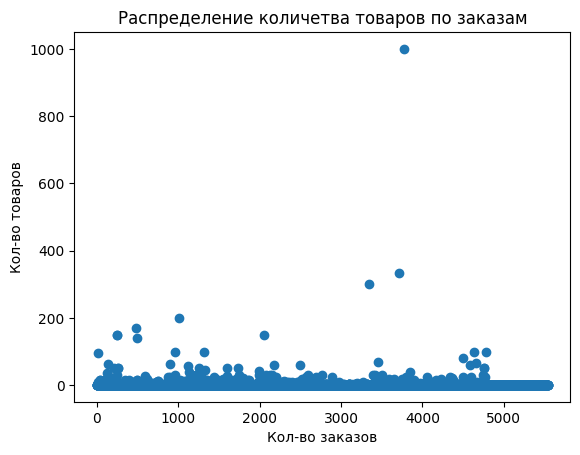

In [21]:
x_values = pd.Series(range(0,len(data_set['quantity'])))

 
#построим график 
plt.scatter(x_values, data_set['quantity'])
# зададим описание графика 
plt.ylabel('Кол-во товаров') 
plt.xlabel('Кол-во заказов') 
plt.title('Распределение количетва товаров по заказам') 
plt.show() 

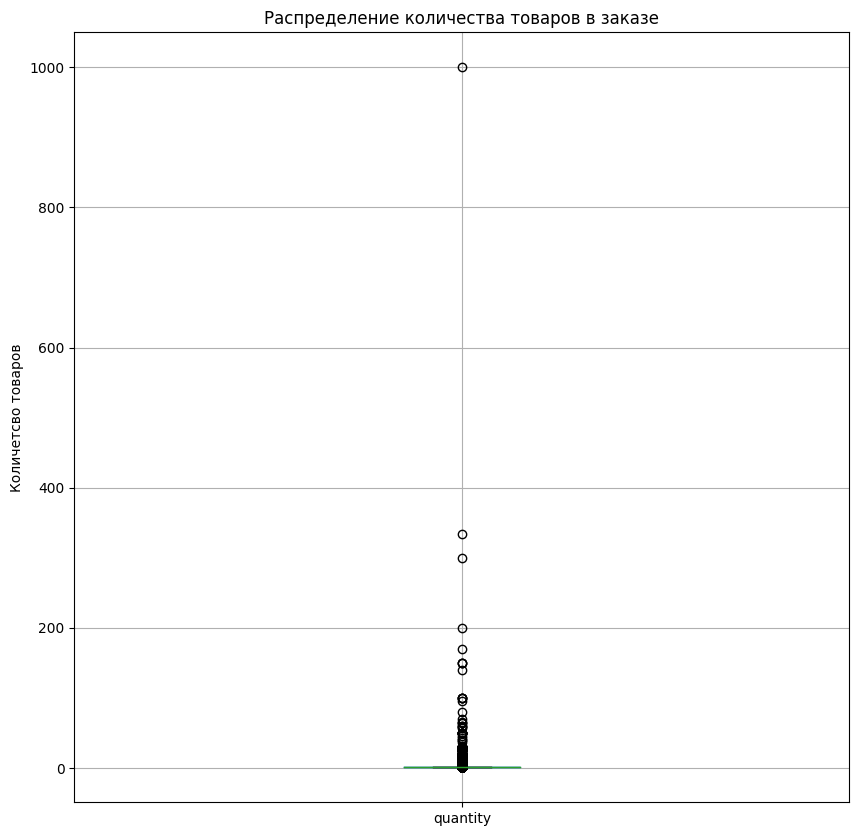

In [22]:
data_set.boxplot(column=['quantity'], figsize=(10,10))

plt.title('Распределение количества товаров в заказе')
plt.ylabel('Количетсво товаров')
plt.show()

Помимо заказа-аутсайдера с 1000 товаров на позицию, наблюдаем еще несколько похожих - например, более 200 шт товаров на одну позицию. Для более точного определения граничных значений посчитаем 95-й и 99-й перцентили:

In [23]:
print(np.percentile(data_set['quantity'], [95, 99]))

[ 6.   25.59]


И так, не более 5 % кладут в корзину > 6 товаров, и не более 1 % кладут в корзину более 26 товаров.

Устанавливать лимиты по количеству товаров не стану, чтобы не потерять оптовых покпателей. Но все же посмотрим, что покупали в большом количестве: 

In [24]:
delete_quantity = data_set[data_set['quantity']>100]
delete_quantity

,date,customer_id,order_id,product,quantity,price,year_month,purchase
241,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2018-10,2850.0
242,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,2018-10,5700.0
479,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,8670.0
497,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,2018-11,8260.0
1007,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,2018-12,5800.0
2048,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,плечики пластмассовые размер 52 - 54 тула 1205158,150,20.0,2019-03,3000.0
3349,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,2019-05,15300.0
3712,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06,49432.0
3779,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,2019-06,675000.0


Обычно, в большом количестве приобретались товары, которые предполагают использование в большом количестве или запасное (муляж яблок, крепеж, пржины). Однако cнова выбивается заказ в 1000 единиц товара "вантуз с деревянной ручкой" - трудно дать логичное объяснение данному заказу, для чистоты эксперимента - удалим данный заказ: 

In [25]:
data = data_set.drop(index=[3779])
data= data.reset_index(drop=True)
data

,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0
...,...,...,...,...,...,...,...,...
5536,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01,76.0
5537,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01,869.0
5538,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01,354.0
5539,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01,128.0


Теперь рассмотрим стоимость товаров:

In [26]:
data['price'].describe()

count     5541.000000
mean       530.504978
std        973.991427
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

Итак, минимальная стоимость - 9 у.е., максимальная 14917, средняя цена товара 530 у.е., стандартное отклонение = 974 намекает о ценовом разбросе, посмотрим на распределение цен:

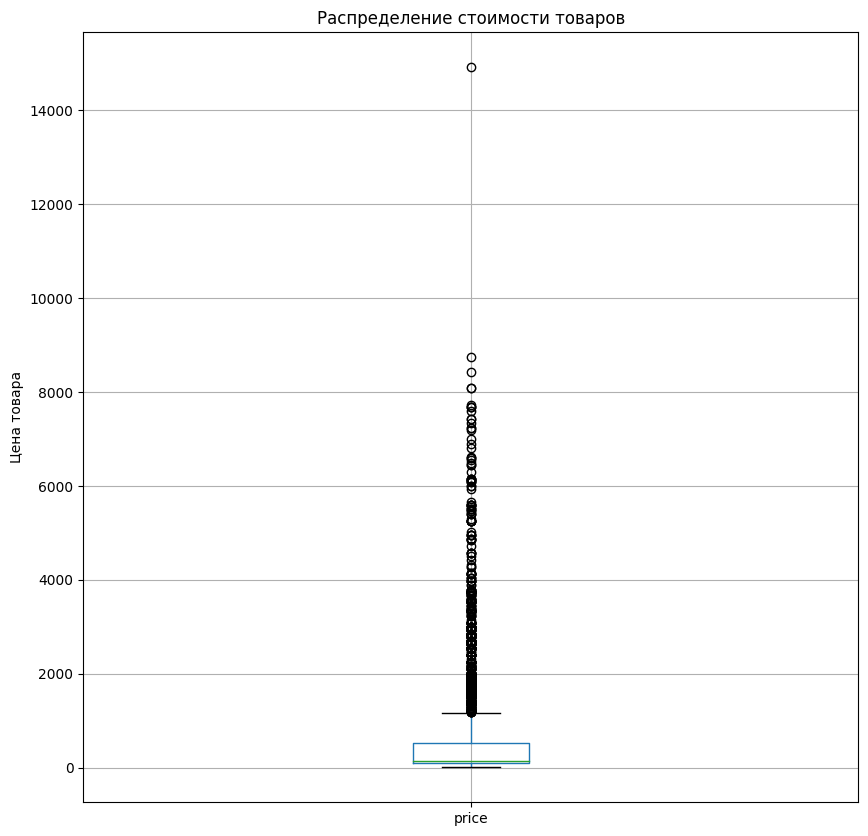

In [27]:
data.boxplot(column=['price'], figsize=(10,10))

plt.title('Распределение стоимости товаров')
plt.ylabel('Цена товара')
plt.show()

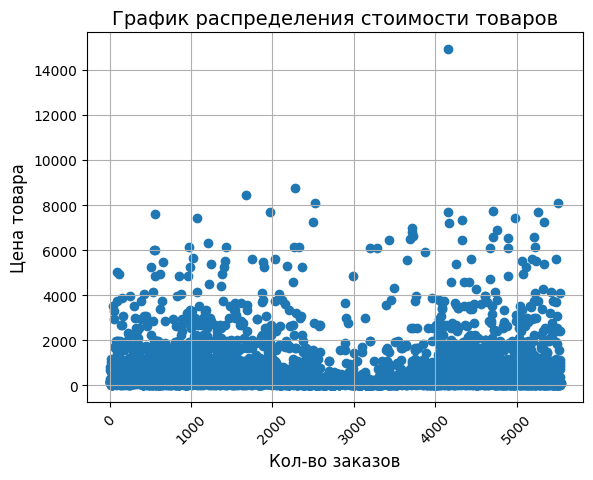

In [28]:
x_values = pd.Series(range(0,len(data['price'])))
plt.scatter(x_values, data['price']) 

plt.grid(visible=True)
plt.title('График распределения стоимости товаров', fontsize=14)
plt.xlabel('Кол-во заказов', fontsize=12)
plt.ylabel('Цена товара', fontsize=12)
plt.xticks(rotation=45) 
plt.show()

In [29]:
print(np.percentile(data['price'], [95, 99]))

[2399. 5249.]


Получается, что **не более 5% товаров имеют стоимость свыше 2 399 у.е., и не более 1% - стоимость более 5 249 у.е.** Не хочется устанавливать границу для стоимости товаров, чтобы не потерять ценню инормацию (может, данные товары образуют касту премиум товаров или что-то типа этого (может, это раздел мебели)).

Посмотрим, насколько наши покупатели полны энтузиазма и сколько, в среднем, заказов совершают - составим таблицу с заказами на каждого пользователя для уточнения деталей, и рассчитаем 95 и 99 перцентили соответственно:

In [30]:
# соберу таблицу с количетсвом заказов по каждому пользователю:
orders_count = (
   data.groupby('customer_id', as_index=False)
    .agg({'order_id' : 'nunique'})
)

orders_count.columns = ['customer_id', 'orders']

orders_count.sort_values(by='orders', ascending=False).head(10)

,customer_id,orders
1884,c971fb21-d54c-4134-938f-16b62ee86d3b,126
729,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1079,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1718,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
687,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
1789,bea7a833-2074-42db-bc49-4457abd3c930,4
2109,e0535076-6270-4df2-8621-cb06264a94fa,4
788,552e17df-ba16-4e66-84fb-55a5557a6bea,3
1947,d02429ab-22e0-4ff2-9465-3082befde444,3


In [31]:
# рассчитаем 95 и 99 перцентили
print(np.percentile(orders_count['orders'], [95, 99]))

[2. 3.]


Что ж, достаточно скромно: **не более 5 % покупателей совершают более 2 заказов, и не более 1 % - более 3х заказов.**

Действительно, есть буквально 8 пользователей, которые совершили более 3 заказов. Особенно выделяется пользователь, оформивший 126 заказов. 

Принимаю решение не усттанавливать границу для количества совершенных заказов во избежание потери лояльных покупателей, удалим только сильно выбивающегося покпателя, который совершил 126 заказов: 

In [32]:
# выбираем данного покупателя с его заказами:
delete_customers = data[data['customer_id'] == 'c971fb21-d54c-4134-938f-16b62ee86d3b']
# удаляем найденные строки 
new_dataset = data.drop(delete_customers.index).copy() 
new_dataset = new_dataset.reset_index(drop=True)
new_dataset

,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0
...,...,...,...,...,...,...,...,...
5393,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01,76.0
5394,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01,869.0
5395,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01,354.0
5396,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01,128.0


Так как наша задача выявить кластеры покупателей на основе их трат, посмотрим, сколько тратят наши покупатели и каков средний чек:

In [33]:
#создадим датасет, группируя по покупателю и вычисляя кол-во заказов, суммарные затраты
info_profile = (
  new_dataset.groupby('customer_id', as_index=False)
    .agg({'order_id' : 'nunique',
          'purchase' : 'sum'}
        )
)

info_profile.columns = ['user_id', 'orders', 'total_chek']
# добавим столбце со значением среднего чека
info_profile['avg_chek'] = round(info_profile['total_chek'] / info_profile['orders'], 2)
info_profile.sort_values(by='avg_chek', ascending=False).head(10)

,user_id,orders,total_chek,avg_chek
195,146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,49432.0
1336,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,1,33680.0,33680.0
972,6987e6d6-a63a-4ce2-a2d0-f424092d235e,1,32718.0,32718.0
822,58a4c3cc-504f-43ea-a74a-bae19e665552,2,53232.0,26616.0
263,1b2764ad-9151-4051-a46a-9b01b62e6335,1,24370.0,24370.0
1481,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,1,22056.0,22056.0
1343,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,1,16536.0,16536.0
857,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.0,15300.0
132,0d87f4ae-465a-4fac-81e6-5d629761783e,1,14917.0,14917.0
994,6be74251-7159-4cc0-99fb-d034a17c61b0,1,11250.0,11250.0


In [34]:
info_profile['avg_chek'].describe()

count     2411.000000
mean      1176.572725
std       2112.272459
min         15.000000
25%        300.000000
50%        652.000000
75%       1349.000000
max      49432.000000
Name: avg_chek, dtype: float64

In [35]:
# рассчитаем 95 и 99 перцентили
print(np.percentile(info_profile['avg_chek'], [95, 99]))

[3730.  7717.7]


Что ж - в общем и целом на данный момент можно сказать следующее: минимальный средний чек - 15 у.е., максимальный - 49 432 у.е. Средний чек за весь период - 1 171 у.е. 

Не более 5 % покупателей совершают заказ на средний чек 3 733 у.е., не более 1% - на сумму 7 701 у.е. Здесь данные удалять не буду, так как это база исследования.

**ВЫВОД:** Исследовательский анализ показал, что: 

   - 95% покупателей кладут в корзину менее 6 товаров, в среднем - это 2-3 товара на позицию
   -  заказы с количеством товара 1000 были удалены как аномалии;
   -  ассортименты представлен ценовым разбросом от 9 у.е. до 14 917 у.е., 
   -  95 % покупателей совершают не более 2 заказов,
   -  минимальный средний чек - 15 у.е., максимальный - 49 432 у.е. Средний чек за весь период - 1 171 у.е. 



## категоризация покупателей

### Построение дендограммы и кластеризация пользователей

На данном этапе цель - выделить основные кластеры покупателей, а также выяснить, какие категории товаров они приобретают, в какой сезон, сколько в среднем тратят на это.

Сформируем таблицу, в которой будет отображаться для каждого пользователя количетсо заказов, средний чек, средняя стоимость товара и среднее 
количетсво товаров в заказе:

In [36]:
# собираем таблицу группирую по id покупателей
customer_orders = new_dataset.groupby('customer_id')['order_id'].nunique().reset_index()
customer_orders.rename(columns={'order_id': 'num_orders'}, inplace=True)

# считаем средний чек для каждого покупателя
order_totals = new_dataset.groupby(['customer_id', 'order_id'])['purchase'].sum().reset_index()
avg_chek = order_totals.groupby('customer_id')['purchase'].mean().reset_index()
avg_chek.rename(columns={'purchase': 'avg_chek'}, inplace=True)

# считаем среднюю цену товара в заказе для каждого покупателя
avg_price = new_dataset.groupby('customer_id')['price'].mean().reset_index()
avg_price.rename(columns={'price': 'avg_price'}, inplace=True)

# считаем среднее количество товаров в заказе для каждого покупателя
avg_quantity = new_dataset.groupby('customer_id')['quantity'].mean().reset_index()
avg_quantity.rename(columns={'quantity': 'avg_quantity'}, inplace=True)

In [37]:
# бъединяем все результаты в один датафрейм
customer_profile = pd.merge(customer_orders, avg_chek, on='customer_id')
customer_profile = pd.merge(customer_profile, avg_price, on='customer_id')
customer_profile = pd.merge(customer_profile, avg_quantity, on='customer_id')
# округлим значения до ближайшего целого числа:
customer_profile['avg_chek'] = customer_profile['avg_chek'].round(0)
customer_profile['avg_price'] = customer_profile['avg_price'].round(0)
customer_profile['avg_quantity'] = customer_profile['avg_quantity'].round(0)
# выводим результат с сортировкой по срежднему чеку
customer_profile.sort_values('avg_chek', ascending=False)

,customer_id,num_orders,avg_chek,avg_price,avg_quantity
195,146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,148.0,334.0
1336,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,1,33680.0,173.0,17.0
972,6987e6d6-a63a-4ce2-a2d0-f424092d235e,1,32718.0,574.0,57.0
822,58a4c3cc-504f-43ea-a74a-bae19e665552,2,26616.0,1852.0,15.0
263,1b2764ad-9151-4051-a46a-9b01b62e6335,1,24370.0,4874.0,5.0
...,...,...,...,...,...
2005,d5660bff-407f-463d-b2ff-e90a9ca05976,1,22.0,22.0,1.0
313,21df03ad-d9ac-47e9-a482-5372fd3e2464,1,22.0,22.0,1.0
164,10f79846-2640-4c43-8392-4e76ff5455ef,1,22.0,22.0,1.0
1406,9777b839-4212-41bb-94c2-87de3658248a,1,15.0,15.0,1.0


Получилии информацию по 2412 нашим уникальным пользователям. 

Передадим данну информацию на получение дендограммы, на основе которой далее выберем число кластеров для модели.

Также предлагаю по полученной сводке построить матрицу корреляции для проверки взаимосвязи среднего чека, стоимости и количства товара в корзине:

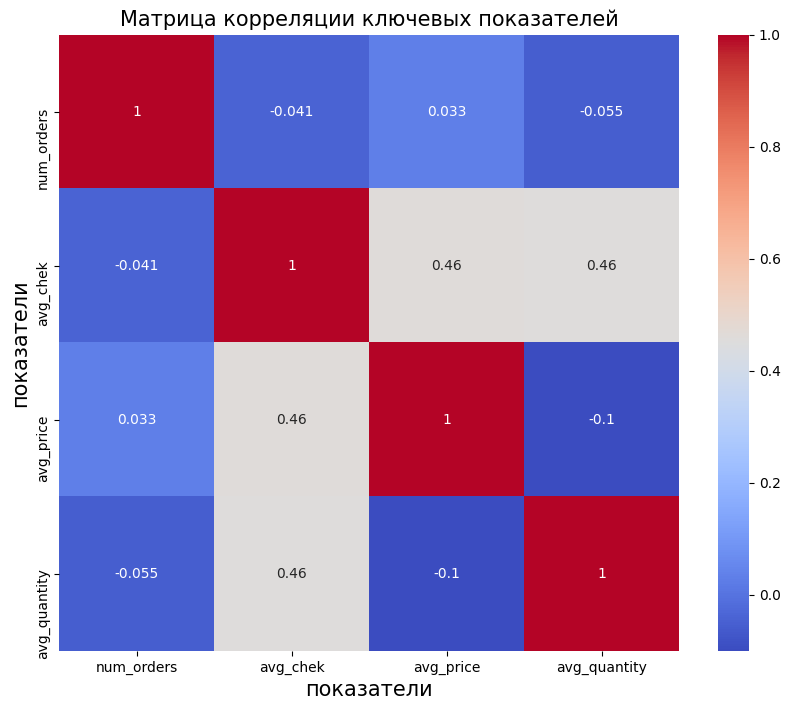

In [38]:
matrica = customer_profile.corr()
plt.figure(figsize=(10,8))
sns.heatmap(matrica, annot = True, square=False, cmap= 'coolwarm')
plt.title('Матрица корреляции ключевых показателей', fontsize = 15)
plt.xlabel('показатели', fontsize = 15) 
plt.ylabel('показатели', fontsize = 15) 
plt.show()

Итак, можно сказать, что в больше степени зависят друг от друга цена товара и чек, чек и количетсво товаров, что вполне логично. В дальнейшем предлагаю делать акцент на стоимость товаров, а не ориентироваться на их количество. 

Построим дендрограму, о которой говорили ранее:

In [39]:
scaler = StandardScaler() # создаём объект класса scaler для стандартизации
x_sc = scaler.fit_transform(customer_profile.drop(columns = ['customer_id']))

In [40]:
# сохраняем таблицу «связок» между объектами - её можно визуализировать как дендрограмму: 
linked = linkage(x_sc, method = 'ward')

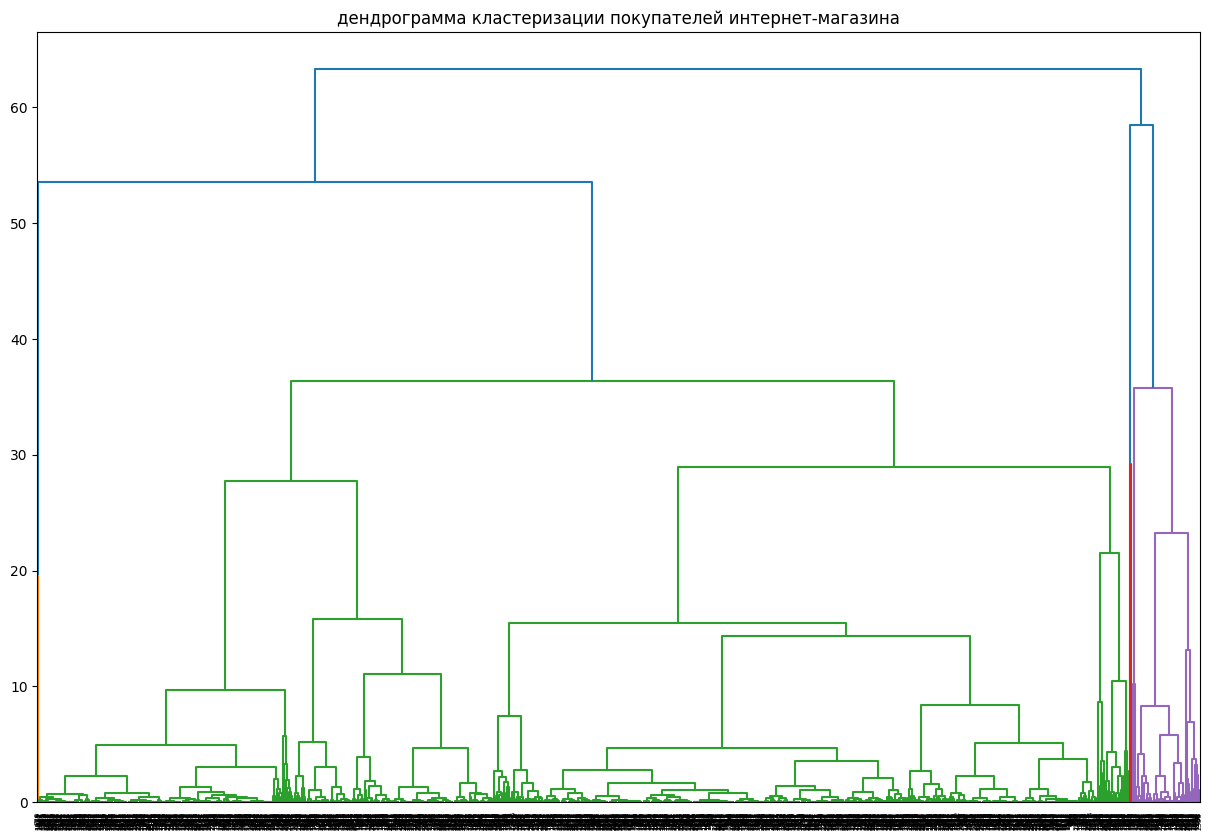

In [41]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('дендрограмма кластеризации покупателей интернет-магазина')
plt.show()

По полученной дендограммы можно предположить 3 кластера для деления наших покупателей (цвета зеленый, красный и фиолетовый)

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем еще один вариант кластеров клиентов. Договоримся за число кластеров принять n=3.

In [42]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X = customer_profile[['num_orders', 'avg_chek', 'avg_price', 'avg_quantity']]
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters=3, random_state=0) # задаём число кластеров = 4, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [43]:
# добавим номер кластера для каждого покупателя
customer_profile['cluster_number'] = labels
customer_profile

,customer_id,num_orders,avg_chek,avg_price,avg_quantity,cluster_number
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,139.0,1.0,1
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,442.0,1.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,457.0,2.0,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1649.0,1.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,1162.0,2.0,1
...,...,...,...,...,...,...
2406,ff601403-b094-4b86-9ac6-264d725b9277,2,870.0,870.0,1.0,1
2407,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,397.0,397.0,1.0,1
2408,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,389.0,389.0,1.0,1
2409,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,974.0,974.0,1.0,1


Выясним, сколько пользователей попали в тот или иной кластер:

In [44]:
customer_profile['cluster_number'].value_counts()

1    2197
0     200
2      14
Name: cluster_number, dtype: int64

Итак, самыми "людными" оказались кластеры О и 1.

Изучим теперь показатели по кластерам (кол-во заказов на покупателя, средний чек, цена и количетсво товаров):

In [45]:
total_cluster_info = customer_profile.groupby('cluster_number').mean().T
total_cluster_info

cluster_number,0,1,2
num_orders,1.655,1.374602,1.000000
avg_chek,4339.900,813.552117,12954.142857
avg_price,3308.815,482.577151,92.428571
avg_quantity,1.830,2.664543,143.857143


Как видим - кластеры получились различные между собой:

**кластер 0** - покупаттели данного кластера покупают самые дорогие товары. по сравнению с остальными (средняя цена 3 308 уе.), и в среднем совершают по 1 заказу, кладут в корзину Ориентировочно по 2 товара; и чаще остальных покупателей совершаю заказов.

**кластрер 1** - данный кластер представлен, скорее всего, самыми "базовыми" покупателями, распространенными: он самый многочисленный, здесь минимальный ср чек по кластерам - 814 у.е., со средней стоимостью товаров 482 у.е.

**кластер 2** - считаю, что данный кластер представлен оптовиками, т.к. количетсво товаров в корзине увеличилось в десятки раз, и средний чек тоже, соответсвенно - самый большой + товары дешевле, чем у других кластеров.

Далее изучим каждый кластер детально - пойдем по-порядку:

### Кластер 0

In [46]:
# сформируем датасет по кластеру 0:
cluster_0 = customer_profile[customer_profile['cluster_number'] == 0]['customer_id'].tolist()
zero_cluster = new_dataset[new_dataset['customer_id'].isin(cluster_0)].reset_index(drop=True)
zero_cluster

,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68485,чехол eurogold clean basic хлопок для досок 12...,1,187.0,2018-10,187.0
1,2018-10-02 10:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68491,сумка-тележка 2-х колесная gimi argo синяя,1,1049.0,2018-10,1049.0
2,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 3-х рядная деревянная 450 мм (пло...,15,49.0,2018-10,735.0
3,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 4-х рядная деревянная 300 мм (фиг...,15,70.0,2018-10,1050.0
4,2018-10-02 14:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"вилка столовая ripple сталь 3 мм, 3 шт, attrib...",1,187.0,2018-10,187.0
...,...,...,...,...,...,...,...,...
372,2020-01-24 03:00:00,3f3cb1b7-b1a6-48ab-b83f-271b4db13752,111302,сушилка для белья gimi mito алюминий,1,1836.5,2020-01,1836.5
373,2020-01-24 16:00:00,1f502315-d58f-401c-8ba2-88b16e53d0b3,110414,гладильная доска hausmann classic mono 120x38 ...,1,2399.0,2020-01,2399.0
374,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0,2020-01,8077.0
375,2020-01-27 14:00:00,c23c92a7-c8d8-46b4-8511-8efdf90d6a55,105214,муляж вишня 3 см 10 шт полиуретан,2,74.0,2020-01,148.0


Выясним, в какой промежуток совершались покупки в данном кластере и с какой прибылью:

In [47]:
# группируем по годам и месяцам и вычисляем общие продажи
date_sales = zero_cluster.groupby('year_month')['purchase'].sum()
date_sales

year_month
2018-10    124304.0
2018-11    106635.0
2018-12     67025.0
2019-01     99654.0
2019-02     73379.0
2019-03     61805.0
2019-04    121006.0
2019-05     51718.0
2019-06     69516.0
2019-07     87309.0
2019-08     71501.0
2019-09     47757.0
2019-10     87715.0
2019-11     48875.5
2019-12     81222.5
2020-01     59377.0
Name: purchase, dtype: float64

Итак, сезон здесь длился год - с октября 2018 по январь 2019 года. Выясним, есть ли сеззонность (пик/спад продаж) ориентируясь так же на прибыль:

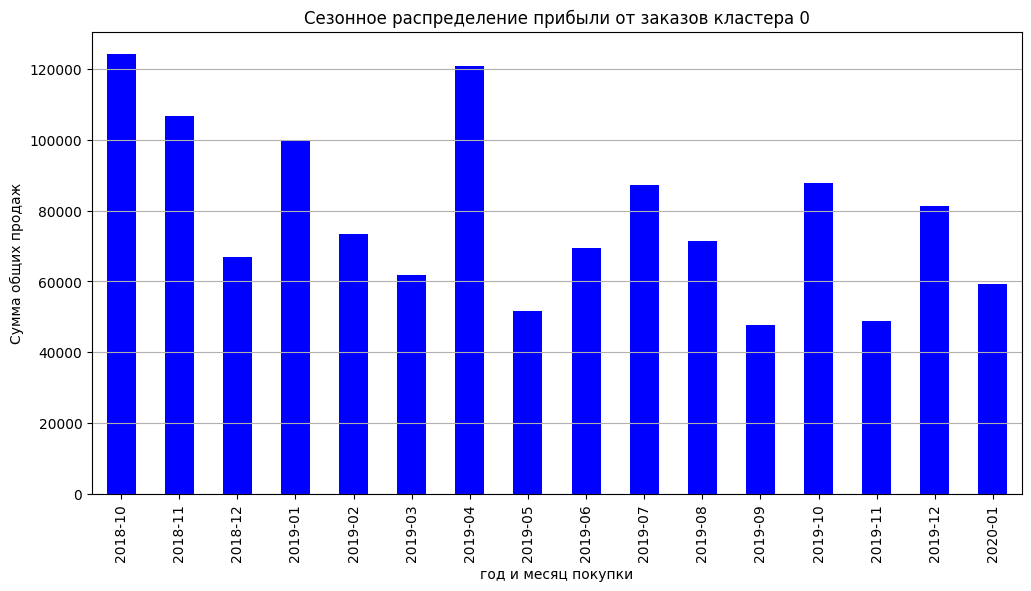

In [48]:
plt.figure(figsize=(12, 6))
date_sales.plot(kind='bar', color='blue')
plt.title('Сезонное распределение прибыли от заказов кластера 0')
plt.xlabel('год и месяц покупки')
plt.ylabel('Сумма общих продаж')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

В данном кластере продажи осуществлялись с окт 2018 по янв 2020. Пик продаж приходится на октябрь, ноябрь 2018 года, январь и апрель 2019,, минимальные продажи - май, сентябрь, ноябрь 2019. 

Узнаем, какие товары предпочитает данная группа покупателей. 

Для этого разобъем все товары на 8 категорий: выделим ключевы слова для распределния списком в словарь (для категории 'семена и растения' решила не перечислять, т.к. их было бОльшое количетсво)

In [49]:
# закомментила код с выводом названий всех товаров в целях экономии загруженности тетради
#all_products = new_dataset['product'].sort_values().to_string(index=False)
#print(all_products)

In [50]:
product_category = {

    'кухонная утварь и посуда':['tepмокружка', 'банка', 'бидон', 'блюдо', 'блюдце', 'бульонница', 'вилка', 'емкость', 
'жестяная', 'измельчитель', 'картофелемялка', 'кастрюля', 'ковш', 'контейнер для свч', 'корыто', 'кружка', 
'крышка', 'кувшин', 'кухонное', 'лопатка', 'лоток', 'мантоварка', 'мерный', 'миксер', 'мини-сковорода', 
'миска', 'модульная', 'доска разделочная', 'контейнер герметичный', 'контейнер для овощей', 'контейнер для приготовления',
'контейнер для продуктов', 'концентрат для мытья', 'котел', 'ложка кухонная', 'ложка столовая', 'ложка чайная',
'масленка коровка', 'набор бокалов', 'набор для пикника', 'набор кружек', 'набор кухонных', 'набор ножей', 
'набор посуды', 'набор стаканов', 'набор форм', 'набор фужеров', 'набор эмалированных', 'нож', 'ножеточка', 
'овощеварка', 'овощечистка', 'орехоколка', 'отделитель', 'подставка для ножей', 'подставка для яйца', 
'половник', 'полотенце кухонное', 'пресс для чеснока', 'просеиватель', 'противень', 'пьезозажигалка', 
'разделочная доска', 'рассекатель пламени', 'рыбочистка', 'салатник', 'салфетница', 'сахарница', 
'сервировочная салфетка', 'сито', 'скалка', 'скатерть', 'сковорода', 'соковарка', 'соковыжималка', 
'сотейник', 'стакан низкий', 'стакан пластмассовый', 'стеклянная крышка', 'столовая ложка', 'столовый нож',
'таз пластмассовый', 'тарелка', 'терка', 'термокружка', 'термос', 'термостакан', 'толкушка', 'фарфоровая кружка', 
'хлебница', 'чайная ложка', 'чайник', 'чайный набор', 'шприц', 'электроштопор', 'ёрш для бутылки'
],

    'уборка':['антижир', 'антинакипин', 'ароматизированное', 'бельевые', 'бензин', 'ведро', 'веник',
'веревка', 'губка', 'жидкое', 'кондиционер', 'концентрат', 'мешок для строительного', 'автоматическая', 
'бальзам', 'комплект для мытья', 'комплект махровых салфеток', 'контейнер для мусора', 'мусорный контейнер',
'набор vileda', 'набор махровых', 'насадка', 'насадка-моп', 'насадка-отжим', 'нетканые салфетки', 
'окномойка', 'ополаскиватель', 'отбеливатель', 'отжим для ведра', 'паста для полировки', 'перчатки', 'пылесос', 
'салфетка', 'скребок', 'сменная', 'сметка', 'совок', 'средство', 'стиральный биопорошок', 'ткань', 
'тряпка', 'универсальное средство', 'чистящий крем', 'швабра', 'щетка', 'ёрш бутылочный', 'ёрш радиаторный' 
],

    'уход и хранение':['вакуумный пакет', 'вешалка', 'вешалки', 'вкладыши', 'гладильная доска', 'защитный', 'защитная', 
'коробка', 'кофр', 'мешок для деликатной', 'доска гладильная', 'декоративная коробка', 'короб стеллажный',
'набор вешалок', 'набор прищепок', 'настенная сушилка', 'настольная гладильная', 'обувница', 'сушилка для белья', 
'плечики', 'подкладка под', 'подрукавник', 'покрытие для гладильной', 'прищепки для белья', 'ролик для чистки', 
'рукав', 'сетка для глажения', 'сетка для стирки', 'сиденье для гладильной', 'складная картонная', 'сменный', 
'стеллаж', 'стяжки для чехла', 'сушилка', 'утюг', 'чехол', 'ящик для хранения'
],

    'все для ванны':['ванна', 'дозатор', 'ерш', 'запасная', 'зубная', 'карниз', 'комплект', 'корзина', 'корзинка', 
'махровое', 'махровый', 'мыло', 'ароматизированное', 'вантуз', 'держатель', 'комплект для ванной', 'комплект махровых полотенец', 
'мыло-скраб', 'мыльница', 'набор ковров для ванной', 'паста зубная', 'пена для ванн', 'подголовник', 'полотенце махровое',
'полотенце прессованное', 'пробка для ванны', 'сиденье в ванну', 'сиденье для унитаза', 'стакан для ванной', 'таз алюминиевый',
'таз пластмассовый со стиральной', 'тряпкодержатель', 'увлажняющая маска', 'фен дорожный', 'халат вафельный', 
'штанга для ванной', 'штора', 'ёрш унитазный' 
],

 
    'инструменты и все для дома':['завертка', 'измерительный', 'ковер', 'коврик', 'ковёр', 'комод', 'крепеж',
'лестница', 'линейка', 'ложка обувная', 'весы', 'кольца для штор', 'комод', 
'крепеж', 'крючок', 'набор инструментов', 'набор прецизионных', 'набор сверел', 'петля приварная', 'петля-стрела', 
'полка для обуви', 'полки qwerty', 'ручка мебельная', 'ручка-скоба', 'сверло', 'сверло-фреза', 'стремян',
'стяжка', 'сумка', 'сумка для тележки', 'таз пластмассовый строительный', 'тележка', 'термометр', 'уголок оконный', 'универсальный нож', 
'урна', 'холодная сварка', 'шило', 'шнур', 'шпагат', 'шпингалет', 'штангенциркуль', 'этажерка', 'ящик почтовый' 
],

    'спальня':['двуспальное', 'комплект постельного белья', 'наволочка', 'наматрасник', 
'наматрицник', 'одеяло', 'плед', 'пододеяльник', 'подушка', 'покрывало', 'простынь', 'простыня'
],


    'декор': ['декоративная композиция', 'искусственная', 'искусственный', 'муляж', 'ваза', 'ключница картина',
'подвесное кашпо', 'подставка для цветов', 'салфетка на стол', 'складной детский', 'цветок искусственный' 
]
}

In [51]:
# функция для присвоения категории товара, которая определит категорию на основе ключевых слов: 
def categorize_product(products):
       for category, items_products in product_category.items():
        for item in items_products:
            if item in products:
                return category  # возвращаем категорию, если нашли совпадение
    # если ни одно совпадение не найдено, возвращаем 'семена и растения'
       return 'семена и растения'

In [52]:
# добавляем столбуц с категорие в датафрейм по кластеру 0: 
zero_cluster['category'] = zero_cluster['product'].apply(categorize_product)
zero_cluster.tail()

,date,customer_id,order_id,product,quantity,price,year_month,purchase,category
372,2020-01-24 03:00:00,3f3cb1b7-b1a6-48ab-b83f-271b4db13752,111302,сушилка для белья gimi mito алюминий,1,1836.5,2020-01,1836.5,уход и хранение
373,2020-01-24 16:00:00,1f502315-d58f-401c-8ba2-88b16e53d0b3,110414,гладильная доска hausmann classic mono 120x38 ...,1,2399.0,2020-01,2399.0,уход и хранение
374,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0,2020-01,8077.0,инструменты и все для дома
375,2020-01-27 14:00:00,c23c92a7-c8d8-46b4-8511-8efdf90d6a55,105214,муляж вишня 3 см 10 шт полиуретан,2,74.0,2020-01,148.0,декор
376,2020-01-28 21:00:00,709dabff-4d9a-4ab0-9e1c-39c253bf90ad,105880,"сумка-тележка хозяйственная rolser paris, борд...",1,4117.0,2020-01,4117.0,инструменты и все для дома


Узнаем предпочтения покупателей данного кластера по полученным категориям товаров и построим круговую диаграмму для наглядности:

In [53]:
# узнаем количетсво заказов на каждую ктегорию товаров
info_categorys_zero = zero_cluster.groupby(['category'])[['order_id']].nunique().sort_values('order_id', ascending=False).reset_index()
info_categorys_zero.rename(columns={'order_id': 'order_count'}, inplace=True)
info_categorys_zero


,category,order_count
0,инструменты и все для дома,149
1,уход и хранение,78
2,кухонная утварь и посуда,31
3,уборка,26
4,семена и растения,24
5,все для ванны,16
6,спальня,9
7,декор,4


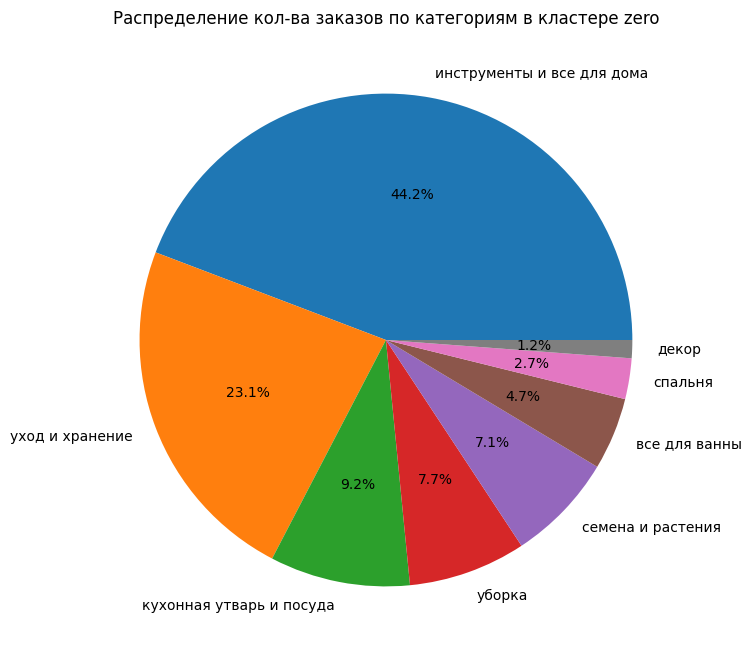

In [54]:
plt.figure(figsize=(8, 8))  
plt.pie(info_categorys_zero['order_count'], labels=info_categorys_zero['category'], autopct='%1.1f%%') 
plt.title('Распределение кол-ва заказов по категориям в кластере zero') 
plt.show()

В данном кластере почти половина покупателей отдавали предпочтение категории **"инструменты и все для дома"** 44,2% заказрв, на втором месте - **уход и хранение 23,1%**, и третье место "кухонная утварь и посуда"** - 9.2%. 

Посмотрим на наличие сезонности покупок у данного кластера:

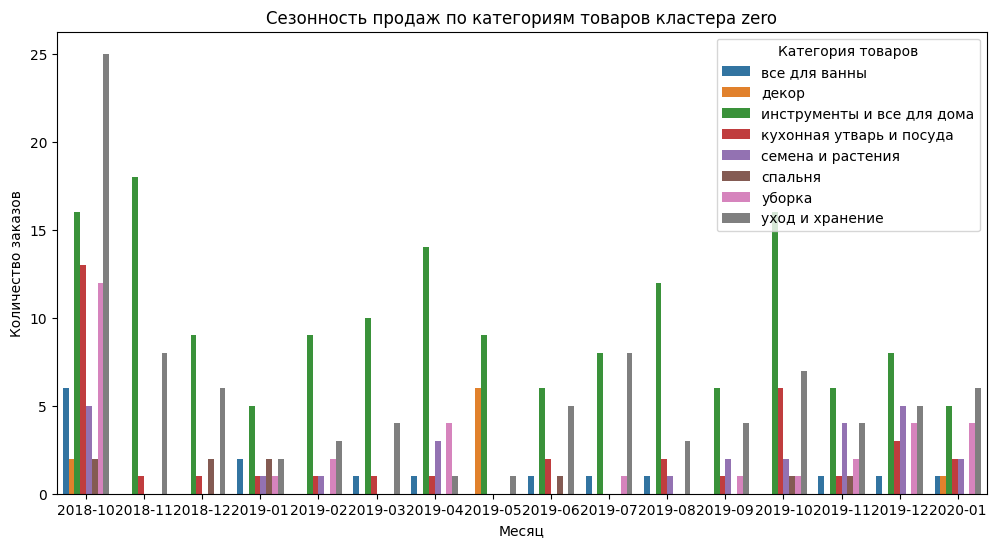

In [55]:
season_sales = zero_cluster.groupby(['year_month', 'category'])['order_id'].count().reset_index()
season_sales = season_sales.rename(columns={'order_id': 'order_count'})

# визуализация с помощью столбчатого графика
plt.figure(figsize=(12, 6))  
sns.barplot(x='year_month', y='order_count', hue='category', data=season_sales)

plt.title('Сезонность продаж по категориям товаров кластера zero')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.legend(title='Категория товаров')

plt.show()


Насчет сезонности - четко прослеживается актуальность категории интсрументы и все для дома - продажи есть каждый месяц, особенно пик виден в ноябре 2018, апреле, августе и октябре 2019, может начало и конец дачных сезонов. Также каждый месяц есть продажи категории уход и хранение, особеноо в окт, ноябре 2018, и июле 2019. Однако есть месяцы, когда продаются по 3 категории - ноябрь 2018, май 2019, 

Теперь выясним прибыльный аспект покупок в данном кластере: средний чек, количетсво товаров и средняя цена товара:

In [56]:
# средний чек
avg_order = zero_cluster.groupby('category')['purchase'].mean().reset_index()
avg_order = avg_order.rename(columns={'purchase': 'mean_chek'})
# прибыль по категории
sum_money = zero_cluster.groupby('category')['purchase'].sum().reset_index()
sum_money = sum_money.rename(columns={'purchase': 'profit'})

# среднее количество купленных товаров на заказ по категориям
avg_quantity = zero_cluster.groupby(['category', 'order_id'])['quantity'].sum().groupby('category').mean().reset_index()


# средняя стоимость товара по категориям
avg_price = zero_cluster.groupby('category')['price'].mean().reset_index()

# объединение результатов
category_result_zero = pd.merge(avg_order, avg_quantity, on='category', how='left')
category_result_zero = pd.merge(category_result_zero, avg_price, on='category', how='left')
category_result_zero = pd.merge(category_result_zero, sum_money, on='category', how='left')
category_result_zero = pd.merge(category_result_zero, info_categorys_zero, on='category', how='left')

# окргулим до целого
category_result_zero['price']=category_result_zero['price'].round(0)
category_result_zero['mean_chek']=category_result_zero['mean_chek'].round(0)
category_result_zero['quantity']=category_result_zero['quantity'].round(0)
# вывод результата с фильтрацией по убыванию прибыли 
category_result_zero.sort_values(by='profit', ascending=False).reset_index(drop=True)

,category,mean_chek,quantity,price,profit,order_count
0,инструменты и все для дома,4071.0,2.0,3739.0,639212.5,149
1,уход и хранение,3027.0,2.0,2587.0,278463.5,78
2,уборка,3720.0,10.0,2066.0,119046.0,26
3,спальня,8842.0,4.0,3239.0,79579.0,9
4,кухонная утварь и посуда,1440.0,2.0,774.0,51833.0,31
5,семена и растения,1873.0,4.0,616.0,48690.0,24
6,все для ванны,1878.0,2.0,1567.0,30051.0,16
7,декор,1325.0,10.0,371.0,11924.0,4


**ВЫВОД**: 

Кластер 0 

1) В данном кластере почти половина покупателей отдавали предпочтение категории "инструменты и все для дома" 44,2% заказрв, на втором месте - уход и хранение 23,1%, и третье место "кухонная утварь и посуда"** - 9.2%.

2) Насчет сезонности - четко прослеживается актуальность категории интсрументы и 
все для дома - продажи есть каждый месяц, особенно пик виден в ноябре 2018, 
апреле, августе и октябре 2019, может начало и конец дачных сезонов. 
Также каждый месяц есть продажи категории уход и хранение, особеноо в окт, ноябре 2018, и июле 2019. Однако есть месяцы, когда продаются по 3 категории - ноябрь 2018, май 2019.

3) несмотря на то, то больше заказов совршенно в категории инструменты и все для дома (149), 
"уход и хранение" (есть товары в 78 заказах) и уборка, по количетсву товаров в корзине это от 2 до 10 товаров, + в категории 
"инструменты и все для дома" попадают самые дорогие товары.

4) Больше всего товаров на позицию приходилось в категориях "уборка" и "декор"- в среднем по 10 товаров соответственно. 

### КЛАСТЕР 1

Также собираем общую информацию по след кластеру покупателей:

In [57]:
cluster_1 = customer_profile[customer_profile['cluster_number'] == 1]['customer_id'].tolist()
one_cluster = new_dataset[new_dataset['customer_id'].isin(cluster_1)].reset_index(drop=True)
one_cluster

,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0
...,...,...,...,...,...,...,...,...
4996,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01,76.0
4997,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01,869.0
4998,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01,354.0
4999,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01,128.0


Добавим информацию по категориям товаров:

In [58]:
one_cluster['category'] = one_cluster['product'].apply(categorize_product)
one_cluster.head()

,date,customer_id,order_id,product,quantity,price,year_month,purchase,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10,142.0,семена и растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10,194.0,семена и растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10,112.0,семена и растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10,179.0,семена и растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10,112.0,семена и растения


In [59]:
info_categorys_1 = one_cluster.groupby(['category'])[['order_id']].nunique().sort_values('order_id', ascending=False).reset_index()
info_categorys_1.rename(columns={'order_id': 'order_count'}, inplace=True)
info_categorys_1

,category,order_count
0,семена и растения,1005
1,уход и хранение,558
2,инструменты и все для дома,476
3,кухонная утварь и посуда,435
4,все для ванны,274
5,декор,239
6,уборка,140
7,спальня,14


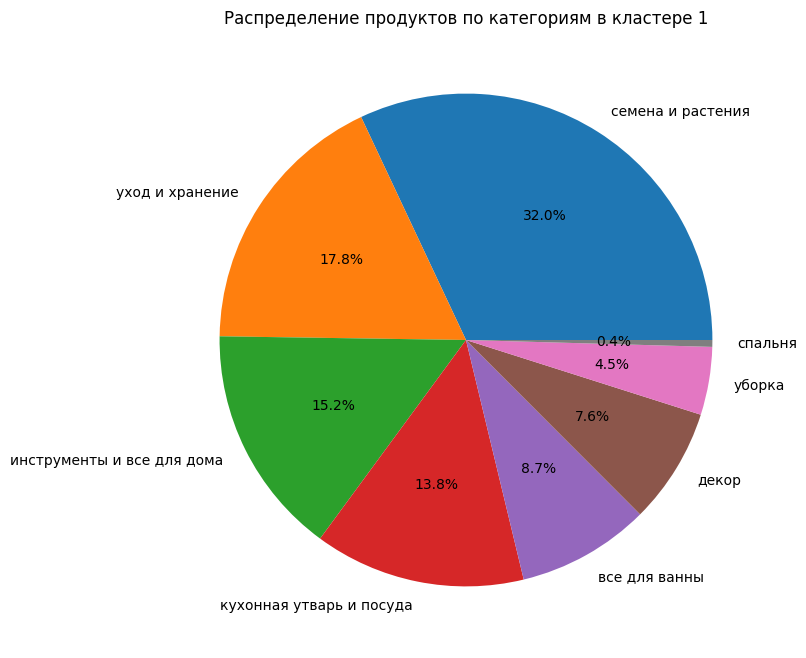

In [60]:
plt.figure(figsize=(8, 8))  
plt.pie(info_categorys_1['order_count'], labels=info_categorys_1['category'], autopct='%1.1f%%') 
plt.title('Распределение продуктов по категориям в кластере 1') 
plt.show()


В данной группе покупателей больше всего заказов в категории **"семена и растения"** 32%, на втором месте - **"уход и хранение"** 17.8%, и на третьем месте - **"инструменты и все для дома"** 15.2%.

Выясним распределение совершения покупок во времени:

In [61]:
# группируем по годам и месяцам и вычисляем общие продажи
date_sales_1 = one_cluster.groupby('year_month')['purchase'].sum()
date_sales_1

year_month
2018-10    185633.000000
2018-11    177546.000000
2018-12    190038.000000
2019-01    122255.000000
2019-02    186739.000000
2019-03    177183.000000
2019-04    195116.000000
2019-05    162768.000000
2019-06    119535.000000
2019-07    139291.000000
2019-08    109409.000000
2019-09    130165.000000
2019-10    114542.000000
2019-11     79916.250000
2019-12    121662.833333
2020-01    114659.333333
Name: purchase, dtype: float64

В данном кластере временной отрезок больше - с октября 2018 по январь 2020. Визуализируем полученную информацию:

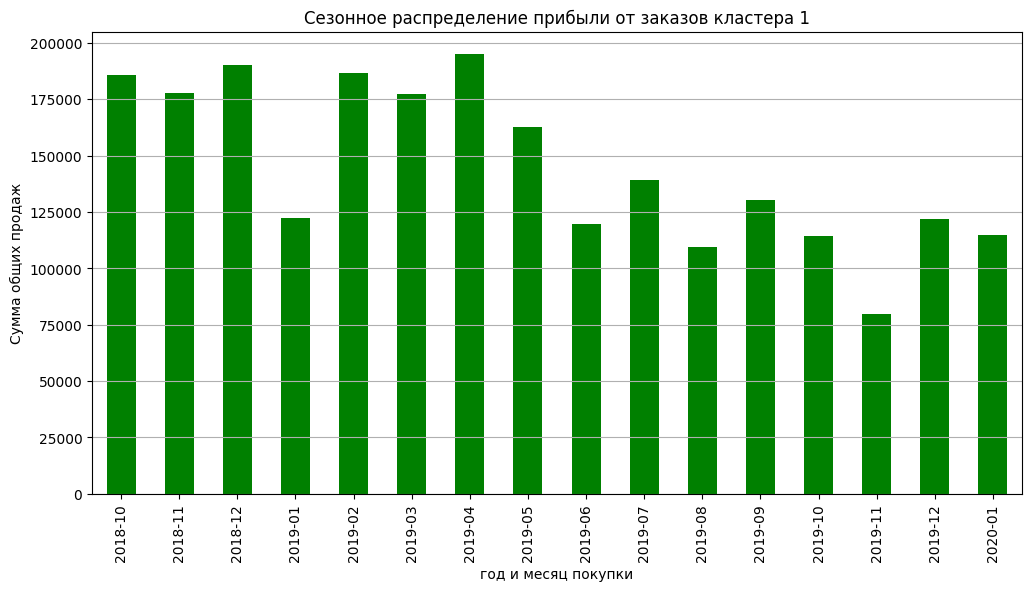

In [62]:
plt.figure(figsize=(12, 6))
date_sales_1.plot(kind='bar', color='green')
plt.title('Сезонное распределение прибыли от заказов кластера 1')
plt.xlabel('год и месяц покупки')
plt.ylabel('Сумма общих продаж')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

Итак, в целом, данный кластер активно тратится на покупки: тратил больше денег с окт по дек 2018, и с февраля по май 2019, минимальные продажи были в январе, августе и ноябре 2019. Перед новогодними праздниками продажи возрастали. 

Посмотрим более детально - какие категории товаров были особенно популярны и в какое время:

In [63]:
season_sales_1 = one_cluster.groupby(['year_month', 'category'])['order_id'].count().reset_index()
season_sales_1 = season_sales_1.rename(columns={'order_id': 'order_count'})

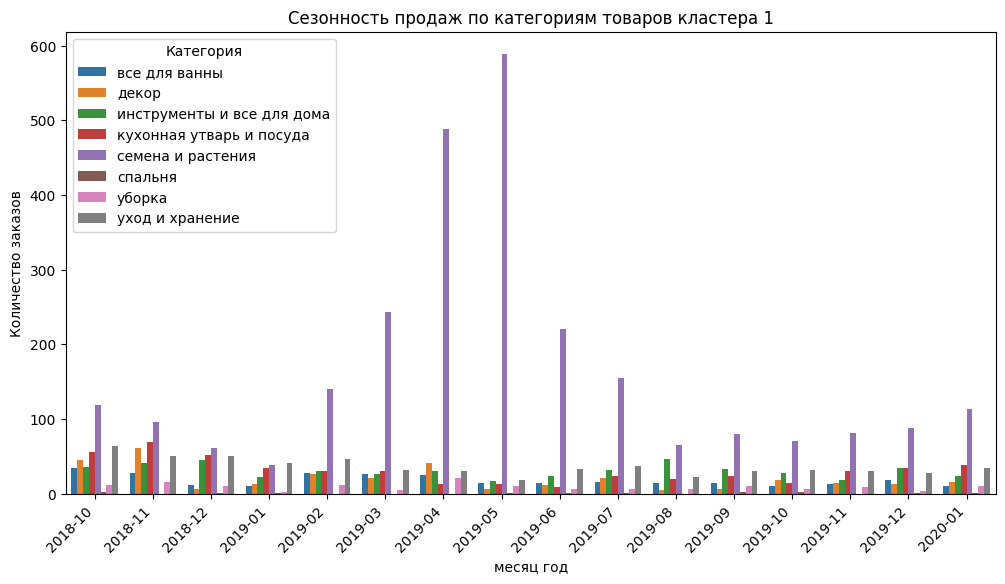

In [64]:
# визуализация с помощью столбчатого графика
plt.figure(figsize=(12, 6)) 

sns.barplot(x='year_month', y='order_count', hue='category', data=season_sales_1)

plt.title('Сезонность продаж по категориям товаров кластера 1')
plt.xlabel('месяц год')
plt.ylabel('Количество заказов')
plt.legend(title='Категория', loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()


Итак, очевидный всплеск продаж категории "семена и растения" в данном кластере наблюдается в ареле-мае 2019  и в приципе хорошая динамика наблюдается с февраля по июль - скорее всего, это подготовка к дачному сезону и его разгар. Все остальные категории товаров имеют значительно меньшие продажи. 
Категория "уход и хранение" продается во все месяцы, особенно с окт 2018 по фев 2019, и июнь-июль 2019, возможно, связано с потребностью убирать вещи в конце года и после летнего сезона. Также во все время актуальна категория "инструменты и все для дома", особенно с окт по дек 2018, и август 2019.

Узнаем более детально прибыльную сторону вопроса: добавим средний чек, среднюю цену товара

In [65]:
# средний чек
avg_order_1 = one_cluster.groupby('category')['purchase'].mean().reset_index()
avg_order_1 = avg_order_1.rename(columns={'purchase': 'mean_chek'})
# прибыль по категории
sum_money_1 = one_cluster.groupby('category')['purchase'].sum().reset_index()
sum_money_1 = sum_money_1.rename(columns={'purchase': 'profit'})
# среднее количество купленных товаров на заказ по категориям
avg_quantity_1 = one_cluster.groupby(['category', 'order_id'])['quantity'].sum().groupby('category').mean().reset_index()


# средняя стоимость товара по категориям
avg_price_1 = one_cluster.groupby('category')['price'].mean().reset_index()

# объединение результатов
category_result_one = pd.merge(avg_order_1, avg_quantity_1, on='category', how='left')
category_result_one = pd.merge(category_result_one, avg_price_1, on='category', how='left')
category_result_one = pd.merge(category_result_one, sum_money_1, on='category', how='left')
category_result_one = pd.merge(category_result_one, info_categorys_1, on='category', how='left')

# окргулим до целого
category_result_one['price']=category_result_one['price'].round(0)
category_result_one['mean_chek']=category_result_one['mean_chek'].round(0)
category_result_one['quantity']=category_result_one['quantity'].round(0)
category_result_one['profit']=category_result_one['profit'].round(0)
# вывод результата с фильтрацией по убыванию стоимости товара 
category_result_one.sort_values(by='profit', ascending=False).reset_index(drop=True)

,category,mean_chek,quantity,price,profit,order_count
0,уход и хранение,933.0,2.0,771.0,545935.0,558
1,инструменты и все для дома,1097.0,2.0,1009.0,536473.0,476
2,семена и растения,193.0,4.0,148.0,511967.0,1005
3,кухонная утварь и посуда,643.0,3.0,399.0,318480.0,435
4,все для ванны,677.0,2.0,560.0,195715.0,274
5,уборка,722.0,4.0,447.0,108318.0,140
6,декор,289.0,7.0,102.0,94395.0,239
7,спальня,1084.0,1.0,982.0,15176.0,14


ВЫВОД: 

Кластер 1:

1) В данной группе покупателей больше всего заказов в категории **"семена и растения"** 32%, на втором месте - **"уход и хранение"** 17.8%, и на третьем месте - **"инструменты и все для дома"** 15.2%.

2) В целом, данный кластер активно тратится на покупки: тратил больше денег с окт по дек 2018, и с февраля по май 2019, минимальные продажи были в январе, августе и ноябре 2019. Перед новогодними праздниками продажи возрастали.  

3) Итак, очевидный всплеск продаж категории "семена и растения" в данном кластере наблюдается в ареле-мае 2019  и в приципе хорошая динамика наблюдается с февраля по июль - скорее всего, это подготовка к дачному сезону и его разгар. Все остальные категории товаров имеют значительно меньшие продажи. 
Категория "уход и хранение" продается во все месяцы, особенно с окт 2018 по фев 2019, и июнь-июль 2019, возможно, связано с потребностью убирать вещи в конце года и после летнего сезона. Также во все время актуальна категория "инструменты и все для дома", особенно с окт по дек 2018, и август 2019.

4) категорией с самыми дорогими товарами является "инструменты и все для дома" 1009 у.е., 
самыми прибыльными являются категории "уход и хранение", "инструменты и все для дома", "семена и растения" (здесь более дешевые товары).

5) самый многочисленный кластер,предполагаю, что данный кластер представлен покупателями, у которых есть дача/частный дом.

### КЛАСТЕР 2

По аналогии с предыдущими кластерами - делаем то же самое с оставшимися:

In [66]:
cluster_2 = customer_profile[customer_profile['cluster_number'] == 2]['customer_id'].tolist()
two_cluster = new_dataset[new_dataset['customer_id'].isin(cluster_2)].reset_index(drop=True)
two_cluster

,date,customer_id,order_id,product,quantity,price,year_month,purchase
0,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38.0,2018-10,3648.0
1,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2018-10,2850.0
2,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,2018-10,5700.0
3,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,8670.0
4,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,2018-11,8260.0
5,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,кухонные ножницы webber из нержавеющей стали с...,2,127.0,2018-11,254.0
6,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457.0,2018-11,29248.0
7,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для мяса с пластмассовой ручкой 3...,6,127.0,2018-11,762.0
8,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для овощей с деревянной ручкой 31...,3,142.0,2018-11,426.0
9,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный универсальный с пластмассовой руч...,24,119.0,2018-11,2856.0


In [67]:
two_cluster['category'] = two_cluster['product'].apply(categorize_product)
two_cluster.head(10)

,date,customer_id,order_id,product,quantity,price,year_month,purchase,category
0,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный 2-х рожковый серый металлик с п...,96,38.0,2018-10,3648.0,инструменты и все для дома
1,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,2018-10,2850.0,инструменты и все для дома
2,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,2018-10,5700.0,все для ванны
3,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,2018-11,8670.0,декор
4,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,2018-11,8260.0,декор
5,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,кухонные ножницы webber из нержавеющей стали с...,2,127.0,2018-11,254.0,кухонная утварь и посуда
6,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457.0,2018-11,29248.0,кухонная утварь и посуда
7,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для мяса с пластмассовой ручкой 3...,6,127.0,2018-11,762.0,кухонная утварь и посуда
8,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный для овощей с деревянной ручкой 31...,3,142.0,2018-11,426.0,кухонная утварь и посуда
9,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,нож кухонный универсальный с пластмассовой руч...,24,119.0,2018-11,2856.0,кухонная утварь и посуда


In [68]:
info_categorys_2 = two_cluster.groupby(['category'])[['order_id']].nunique().sort_values('order_id', ascending=False).reset_index()
info_categorys_2.rename(columns={'order_id': 'order_count'}, inplace=True)
info_categorys_2

,category,order_count
0,инструменты и все для дома,6
1,декор,3
2,уборка,2
3,уход и хранение,2
4,все для ванны,1
5,кухонная утварь и посуда,1


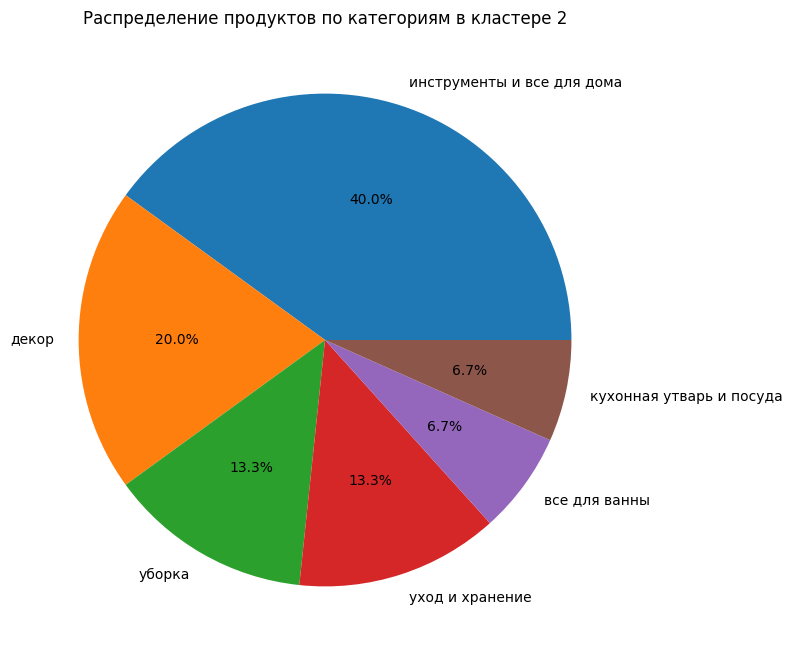

In [69]:
plt.figure(figsize=(8, 8))  
plt.pie(info_categorys_2['order_count'], labels=info_categorys_2['category'], autopct='%1.1f%%') 
plt.title('Распределение продуктов по категориям в кластере 2') 
plt.show()

В кластере 2 ситуация изменилась: 40% заказов с категорией "инструменты и все для дома", 20% "декор" и поровну "уборка" и "уход и хранение" по 13.3%.

Выясним распределение заказов во времени:

In [70]:
season_sales_2 = two_cluster.groupby(['year_month', 'category'])['order_id'].count().reset_index()
season_sales_2 = season_sales_2.rename(columns={'order_id': 'order_count'})

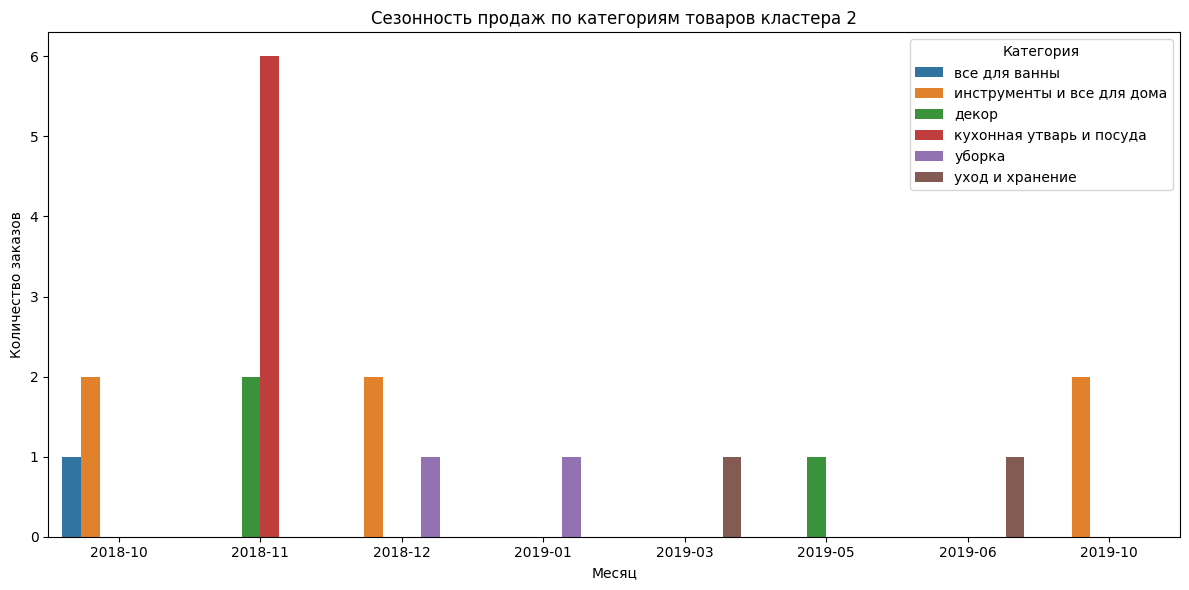

In [71]:
plt.figure(figsize=(12, 6))  

sns.barplot(x='year_month', y='order_count', hue='category', data=season_sales_2)

plt.title('Сезонность продаж по категориям товаров кластера 2')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
 
plt.legend(title='Категория', loc='upper right')
plt.tight_layout()  
plt.show()

Как таковой сезонности по заказам в данном кластере назвать не получается, если только отметить пики продаж категории "декор" и "кухонная утварь" в ноябре 2018 - скорее всего, перед праздниками, категория "инструменты и все для дома" была востребована в октябре'18, декабре'18 и снова в окт'19. Заказы с категорие "Уход и хранение" были только в марте и июне 2019. В феравле, апреле, июль-сентябрь, и после октября 2019 г - заказов в данном кластере не было вовсе. 

In [72]:
# средний чек
avg_order_2 = two_cluster.groupby('category')['purchase'].mean().reset_index()
avg_order_2 = avg_order_2.rename(columns={'purchase': 'mean_chek'})
# прибыль по категории
sum_money_2 = two_cluster.groupby('category')['purchase'].sum().reset_index()
sum_money_2 = sum_money_2.rename(columns={'purchase': 'profit'})
# среднее количество купленных товаров на заказ по категориям
avg_quantity_2 = two_cluster.groupby(['category', 'order_id'])['quantity'].sum().groupby('category').mean().reset_index()


# средняя стоимость товара по категориям
avg_price_2 = two_cluster.groupby('category')['price'].mean().reset_index()

# объединение результатов
category_result_2 = pd.merge(avg_order_2, avg_quantity_2, on='category', how='left')
category_result_2 = pd.merge(category_result_2, avg_price_2, on='category', how='left')
category_result_2 = pd.merge(category_result_2, sum_money_2, on='category', how='left')
category_result_2 = pd.merge(category_result_2, info_categorys_2, on='category', how='left')

# окргулим до целого
category_result_2['price']=category_result_2['price'].round(0)
category_result_2['mean_chek']=category_result_2['mean_chek'].round(0)
category_result_2['quantity']=category_result_2['quantity'].round(0)
category_result_2['profit']=category_result_2['profit'].round(0)
# вывод результата с фильтрацией по убыванию стоимости товара 
category_result_2.sort_values(by='profit', ascending=False).reset_index(drop=True)

,category,mean_chek,quantity,price,profit,order_count
0,уход и хранение,26216.0,242.0,84.0,52432.0,2
1,инструменты и все для дома,8553.0,117.0,120.0,51316.0,6
2,кухонная утварь и посуда,5613.0,101.0,173.0,33680.0,1
3,декор,10743.0,203.0,54.0,32230.0,3
4,уборка,3000.0,100.0,30.0,6000.0,2
5,все для ванны,5700.0,150.0,38.0,5700.0,1


Покупатели данного кластера хоть и делали покупки редко, но с большим количетсвом товаров от 100 шт, причем
сама стоимсоть товаров не велика от 30 у.е. до 173 у.е. Больше всего товаров попадало в корзину из категорий "уход и хранение" по 242 шт на позицию, 
"декор" 203 шт, и все для "ванны" 150 шт. Самыми прибыльными оказались категории "уход и хранение", "инструменты и все для дома" и "кухонная утварь". 

**ВЫВОД**:

Кластер 2 

1) самый малочисленный по количетсву заказов кластер, но при этом - с большим количеством
товаров по позиции в заказе

2) В кластере 2 ситуация изменилась: 40% заказов с категорией "инструменты и все для дома", 20% "декор" и поровну "уборка" и "уход и хранение" по 13.3%.

3) Как таковой сезонности по заказам в данном кластере назвать не получается, если только отметить пики продаж категории "декор" и "кухонная утварь" в ноябре 2018 - скорее всего, перед праздниками, категория "инструменты и все для дома" была востребована в октябре'18, декабре'18 и снова в окт'19. Заказы с категорие "Уход и хранение" были только в марте и июне 2019. В феравле, апреле,
 июль-сентябрь, и после октября 2019 г - заказов в данном кластере не было вовсе. 

4) Покупатели данного кластера хоть и делали покупки редко, но с большим количетсвом товаров от 100 шт, причем
сама стоимсоть товаров не велика от 30 у.е. до 173 у.е. Больше всего товаров попадало в корзину из категорий "уход и хранение" по 242 шт на позицию, 
"декор" 203 шт, и все для "ванны" 150 шт. Самыми прибыльными оказались категории "уход и хранение", "инструменты и все для дома" и "кухонная утварь".

5) похоже, что в данном кластере имеем дело с оптовиками.


**Итог**:
  Итак, по результатам кластеризации методом K-means можно выделить следующие 3 кластера:
  
**Кластер 0**


1) В данном кластере почти половина покупателей отдавали предпочтение категории "инструменты и все для дома" 44,2% заказрв, на втором месте - уход и хранение 23,1%, и третье место "кухонная утварь и посуда"** - 9.2%.

2) Насчет сезонности - четко прослеживается актуальность категории интсрументы и 
все для дома - продажи есть каждый месяц, особенно пик виден в ноябре 2018, 
апреле, августе и октябре 2019, может начало и конец дачных сезонов. 
Также каждый месяц есть продажи категории уход и хранение, особеноо в окт, ноябре 2018, и июле 2019. Однако есть месяцы, когда продаются по 3 категории - ноябрь 2018, май 2019.

3) несмотря на то, то больше заказов совршенно в категории инструменты и все для дома (149), 
"уход и хранение" (есть товары в 78 заказах) и уборка, по количетсву товаров в корзине это от 2 до 10 товаров, + в категории 
"инструменты и все для дома" попадают самые дорогие товары.

4) Больше всего товаров на позицию приходилось в категориях "уборка" и "декор"- в среднем по 10 товаров соответственно.



**Кластер 1**


1) В данной группе покупателей больше всего заказов в категории "семена и растения" 32%, на втором месте - "уход и хранение" 17.8%, и на третьем месте - "инструменты и все для дома" 15.2%.


2) В целом, данный кластер активно тратится на покупки: тратил больше денег с окт по дек 2018, и с февраля по май 2019, минимальные продажи были в январе, августе и ноябре 2019. Перед новогодними праздниками продажи возрастали.


3) Итак, очевидный всплеск продаж категории "семена и растения" в данном кластере наблюдается в ареле-мае 2019 и в приципе хорошая динамика наблюдается с февраля по июль - скорее всего, это подготовка к дачному сезону и его разгар. Все остальные категории товаров имеют значительно меньшие продажи. Категория "уход и хранение" продается во все месяцы, особенно с окт 2018 по фев 2019, и июнь-июль 2019, возможно, связано с потребностью убирать вещи в конце года и после летнего сезона. Также во все время актуальна категория "инструменты и все для дома", особенно с окт по дек 2018, и август 2019.

4) категорией с самыми дорогими товарами является "инструменты и все для дома" 1009 у.е., самыми прибыльными являются категории "уход и хранение", "инструменты и все для дома", "семена и растения" (здесь более дешевые товары).

5) предполагаю, что данный кластер представлен покупателями, у которых есть дача/частный дом, и это основная аудитория магазина.


**Кластер 2** 

1) В кластере 2 ситуация изменилась: 40% заказов с категорией "инструменты и все для дома", 20% "декор" и поровну "уборка" и "уход и хранение" по 13.3%.

2) Как таковой сезонности по заказам в данном кластере назвать не получается, если только отметить пики продаж категории "декор" и "кухонная утварь" в ноябре 2018 - скорее всего, перед праздниками, категория "инструменты и все для дома" была востребована в октябре'18, декабре'18 и снова в окт'19. Заказы с категорие "Уход и хранение" были только в марте и июне 2019. В феравле, апреле,
 июль-сентябрь, и после октября 2019 г - заказов в данном кластере не было вовсе. 

3) Покупатели данного кластера хоть и делали покупки редко, но с большим количетсвом товаров, причем
сама стоимсоть товаров не велика от 30 у.е. до 173 у.е. Больше всего товаров попадало в корзину из категорий "уход и хранение" по 242 шт на позицию, 
"декор" 203 шт, и все для "ванны" 150 шт. Самыми прибыльными оказались категории "уход и хранение", "инструменты и все для дома" и "кухонная утварь". 

## Проверка статистических гипотез

Гипотезами проверяем правильность разбиения на кластеры: сформулированы Гипотезы о равенстве средних двух генеральных совокупностей. 

Первая гипотеза звучит так: 

1) Есть ли разница в средних чеках по сегментам (кластерам) покупателей?

Ho - статистическая значимость различий в среднем чеке покупателей по выделенным группами отсутсвует, то есть суммы чеков равны

Н1 - присутсвует статистическая значимость различий в среднем чеке по сегментам покупателей

Проверять гипотезу будем по всем кластерам.

Сформирую таблички с суммой заказов по заказам в каждом кластере:

In [73]:
rez_2 = two_cluster.groupby('order_id')['purchase'].sum().reset_index()
rez_1=one_cluster.groupby('order_id')['purchase'].sum().reset_index()
rez_0=zero_cluster.groupby('order_id')['purchase'].sum().reset_index()

Далее для выбора теста проверим данные на нормальное распределение с помощью Критерия Шапиро-Уилкаю:

In [74]:
alpha = 0.05
tables = {
        "zero_cluster": rez_0,
        "one_cluster": rez_1,
        "two_cluster": rez_2,
}

for cluster_name, rez in tables.items():
    print(f"\nПроверка нормальности для {cluster_name}:")

    results = st.shapiro(rez['purchase'])
    p_value = results[1]

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: распределение, вероятно, нормально')


Проверка нормальности для zero_cluster:
p-значение:  2.205848854957794e-25
Отвергаем нулевую гипотезу: распределение не нормально

Проверка нормальности для one_cluster:
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально

Проверка нормальности для two_cluster:
p-значение:  0.0008441093377768993
Отвергаем нулевую гипотезу: распределение не нормально


Итак, наша проверка показала, что данные по кластерам распределены не нормально + выборки разных размеров. 

Выбираю для проверки гипотез Непараметрический тест Уилкоксона-Манна-Уитни.



Т.к. предстоит множественное тестирование, необходимо провести  коррекцию уровня значимости - Методом Шидака

In [75]:
# подготавливаем данные

m = 6 # число тестов
alpha = 0.05 # исходный уровень значимости

# расчёт коррекции уровня значимости 
alpha_sidak = 1 - ((1 - alpha)**(1/m))  

# считаем FWER
fwer_sidak = 1 - (1 - alpha_sidak)**m

print('скорректированный уровень уровень стат. значимости:', alpha_sidak)
print('FWER:', fwer_sidak)

скорректированный уровень уровень стат. значимости: 0.008512444610847103
FWER: 0.04999999999999993


Далее проведем тест с уровнем **стат значимости 0.0085**. 

Для упрощения процесса - использую функцию: 

In [76]:
from itertools import combinations


def perform_mannwhitneyu(df, alpha=0.0085): 
    results = {}
    group_names = list(df.keys())
    for group1_name, group2_name in combinations(group_names, 2): # перебор по два кластера
        group1_data = df[group1_name]['purchase']
        group2_data = df[group2_name]['purchase']

        results_mannwhitneyu = st.mannwhitneyu(group1_data, group2_data)
        p_value = results_mannwhitneyu.pvalue

        if p_value < alpha:
            significance = 'Отвергаем нулевую гипотезу: разница статистически значима'
        else:
            significance = 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

        results[(group1_name, group2_name)] = {
            'pvalue': p_value,
            'significance': significance
        }

        print(f"Сравнение {group1_name} и {group2_name}:")
        print('p-значение: ', p_value)
        print(significance)
        print("___" * 30)  # разделитель для читаемости

    return results
# словарь с переданными данными
df  = {
        'cluster_0': rez_0,
        'cluster_1': rez_1,
        'cluster_2': rez_2,
    }

In [77]:
results_is = perform_mannwhitneyu(df)

Сравнение cluster_0 и cluster_1:
p-значение:  3.9785759794839123e-97
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________
Сравнение cluster_0 и cluster_2:
p-значение:  0.0010987203409940057
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________
Сравнение cluster_1 и cluster_2:
p-значение:  3.427545907826795e-10
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________


Итак, проверка показала, что в каждом случае мы отвергаем нулевую гипотезу о равенстве средних чеков между кластерами, что подтвержает правильность выделенных кластеров.

**ВТОРАЯ ГИПОТЕЗА**: 

2) Гипотеза о различии средней стоимости товара в корзине:

Ho - Средняя стоимость товаров, приобретаемая покупателем, не различается между кластерами

H1 - Средняя стоимость товаров в корзине покупателей, различается между кластерами

Аналочным способом проверяем вторую гипотезу:

Также проверим данные на "нормальность":

In [78]:
alpha = 0.05
info_price = {
        "zero_cluster": zero_cluster,
        "one_cluster": one_cluster,
        "two_cluster": two_cluster,
}

for cluster_name, rez in info_price.items():
    print(f"\nПроверка нормальности для {cluster_name}:")

    results = st.shapiro(rez['price'])
    p_value = results[1]

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: распределение, вероятно, нормально')


Проверка нормальности для zero_cluster:
p-значение:  4.5302039300854774e-14
Отвергаем нулевую гипотезу: распределение не нормально

Проверка нормальности для one_cluster:
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально

Проверка нормальности для two_cluster:
p-значение:  3.950083737436216e-06
Отвергаем нулевую гипотезу: распределение не нормально


C:\Users\asus\.conda\envs\practicum\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Снова распределение величины не нормально - дальнешие действия те же: тот же тест со стат значимостью 0.008

In [79]:
def perform_mannwhitneyu_2(df_price, alpha=0.0085): 
    results = {}
    group_names = list(df_price.keys())
    for group1_name, group2_name in combinations(group_names, 2): # перебор по два кластера
        group1_data = df_price[group1_name]['price']
        group2_data = df_price[group2_name]['price']

        results_mannwhitneyu = st.mannwhitneyu(group1_data, group2_data)
        p_value = results_mannwhitneyu.pvalue

        if p_value < alpha:
            significance = 'Отвергаем нулевую гипотезу: разница статистически значима'
        else:
            significance = 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

        results[(group1_name, group2_name)] = {
            'pvalue': p_value,
            'significance': significance
        }

        print(f"Сравнение {group1_name} и {group2_name}:")
        print('p-значение: ', p_value)
        print(significance)
        print("___" * 30)  # разделитель для читаемости

    return results
#словарь с переданными данными
df_price  = {
        'zero_cluster': zero_cluster,
        'one_cluster': one_cluster,
        'two_cluster': two_cluster,
}

In [80]:
results_is_2 = perform_mannwhitneyu_2(df_price)

Сравнение zero_cluster и one_cluster:
p-значение:  4.12281255706486e-121
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________
Сравнение zero_cluster и two_cluster:
p-значение:  2.4157644123562092e-11
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________
Сравнение one_cluster и two_cluster:
p-значение:  5.474129952104683e-05
Отвергаем нулевую гипотезу: разница статистически значима
__________________________________________________________________________________________


Проверка второй гипотезы показала, что стоимсоть товаров в корзине покупалей по кластерам различаются, есть основание говорить, что кластеризация прошла успешно.

## общий вывод и рекомендации

В ходе работы над проектом была выполнена:
    
    1) предобработка данных (удаление дубликатов, изменение типов данных, выявление аномалий)
    
    2) исследовательский анализ данных, который показал, что
    
    
   - 95% покупателей кладут в корзину менее 6 товаров, в среднем - это 2-3 товара на позицию
   -  заказы с количеством товара 1000 были удалены как аномалии;
   -  ассортименты представлен ценовым разбросом от 9 у.е. до 14 917 у.е., 
   -  95 % покупателей совершают не более 2 заказов,
   -  минимальный средний чек - 15 у.е., максимальный - 49 432 у.е. Средний чек за весь период - 1 171 у.е. 
    
    3)  выполнена кластеризация покупателей методом K-means,  можно выделить следующие 3 кластера:
    
    
**Кластер 0**

Ключевые характеристики:

• Покупают дорогие товары (средняя цена 3382 у.е.)

• В среднем совершают 1 заказ, являются основной аудиторией магазина

• В корзине около 2 товаров.

• Предпочитают "Инструменты и все для дома" (49.6%), "Уход и хранение" (21.5%).

• Меньше интересуются "Уборкой" (7.8%) и "Кухонной утварью и посудой" (7.4%).

• Сезонность: "Инструменты и все для дома" - ноябрь 2018, апрель, август, октябрь 2019 (начало и конец дачных сезонов?). "Уход и хранение" - октябрь, ноябрь 2018, июль 2019.

*Рекомендации: Стимулировать повторные покупки, увеличить средний чек за счет более дорогих товаров и большего количества товаров в заказе, укрепить лояльность к бренду как поставщику качественных решений для дома, отправлять рассылки с интересными предложениями, особенно в указанные месяцы*

**Кластер 1**

 Клюячевые  моменты:

 • данный кластер представлен, скрее всего, самыми "базовыми" покупателями:

• Самый многочисленный кластер.

• Минимальный средний чек (817 у.е.) и средняя стоимость товара (486 у.е.).

• Основные категории: "Семена и растения" (31.9%), "Уход и хранение" (18%), "Инструменты и все для дома" (15.1%).

• Сезонность: Активность с декабря по май (подготовка к дачному сезону, праздники), спад в январе, августе, ноябре.
Категория "уход и хранение" продается во все месяцы, особенно с окт 2018 по фев 2019, и июнь-июль 2019, возможно, связано с потребностью убирать вещи в конце года и после летнего сезона. Также во все время актуальна категория "инструменты и все для дома", особенно с окт по дек 2018, и август 2019.

• Самые дорогие товары: "Инструменты и все для дома" (1032 у.е.).

• Самые прибыльные категории: "Уход и хранение", "Инструменты и все для дома", "Семена и растения".

• Предположительно, дачники и владельцы частных домов.

*Рекомендации: Увеличение среднего чека и частоты покупок, удержание и вовлечение, предложение новых категорий.*


**Кластер 2** 

•  Предположительно, оптовые покупатели.

•  Большое количество товаров в корзине (в десятки раз больше, чем в других кластерах).

•  Средний чек значительно выше.

•  Относительно низкая стоимость товаров (30-173 у.е.).

•  Основные категории: "Инструменты и все для дома" (40%), "Декор" (20%), "Уборка" и "Уход и хранение" (по 13.3%).

•  Пики продаж: "Декор" и "Кухонная утварь" в ноябре 2018 (перед праздниками), "Инструменты и все для дома" в октябре 2018, декабре 2018, октябре 2019.

•  Редкие, но крупные заказы.

•  Наибольшее количество товаров в корзине из категорий: "Уход и хранение" (242 шт на позицию), "Декор" (203 шт), "Все для ванной" (150 шт).

•  Самые прибыльные категории: "Уход и хранение", "Инструменты и все для дома", "Кухонная утварь".


*Рекомедации: Стимулировать повторные оптовые заказы, расширить ассортимент покупок, укрепить партнерские отношения, предлагая выгодные условия для оптовых закупок.*



        4. Выполнена проверка стат гипотез Непараметрическим тестом Уилкоксона-Манна-Уитни с коррекцией уровня стат.значимости (0.0085)
        
1) **Есть ли разница в средних чеках по сегментам (кластерам) покупателей?**

Ho - статистическая значимость различий в среднем чеке покупателей по выделенным группами отсутсвует, то есть суммы чеков равны

Н1 - присутсвует статистическая значимость различий в среднем чеке по сегментам покупателей

ВТОРАЯ ГИПОТЕЗА:

2) **Гипотеза о различии средней стоимости товара в корзине:**

Ho - Средняя стоимость товаров, приобретаемая покупателем, не различается между кластерами

H1 - Средняя стоимость товаров в корзине покупателей, различается между кластерами
        
 Нулевые гипотезы были отвергнуты, поэтому можно сказать, что кластеризация выполнена верно.      
     